In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import os

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim

from scipy import optimize

from google.colab import drive

In [ ]:
drive.mount('/content/gdrive')

path_dades = "/content/gdrive/MyDrive/Colab Notebooks/postgrau/progecte/propi/dades/data/"

if os.path.exists(path_dades):
    print(f"Directory '{path_dades}' exists.")

Mounted at /content/gdrive
Directory '/content/gdrive/MyDrive/Colab Notebooks/postgrau/progecte/propi/dades/data/' exists.


In [ ]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
#pl.seed_everything(42)

In [ ]:
file_train = 'data_clean_bo.csv'

data = pd.read_csv(path_dades + file_train, index_col="Time", parse_dates=True)

data.head(2)

,Bearing Pressure (kPa),Power Draw (MW),Speed (RPM),Dilution Flow Rate (m3/h),Conveyor Belt Feed Rate (t/h),Conveyor Belt PSD Fines (%)
Time,,,,,,
2015-09-15 00:00:00,5488.175540,19.437357,7.843532,1030.590108,2935.660276,38.641018
2015-09-15 00:01:00,5423.930126,18.543755,7.681607,1039.869847,2928.333772,45.243656


Data is already **clean** and **time consistent**.

## Data Statistcs

In [ ]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Bearing Pressure (kPa),138241.0,5361.523864,202.317644,35.651295,5288.403958,5363.159017,5450.906260,5995.657529
Power Draw (MW),138241.0,17.306089,4.541774,-0.073347,15.100874,18.971277,20.233436,25.904561
Speed (RPM),138241.0,8.010549,1.617348,0.000000,8.057497,8.421999,8.677781,8.730035
Dilution Flow Rate (m3/h),138241.0,914.572301,253.076717,0.000000,844.107699,954.845114,1052.036404,1636.474899
Conveyor Belt Feed Rate (t/h),138241.0,2397.461253,667.784258,0.000000,2214.845016,2595.094886,2816.978574,3594.124010
Conveyor Belt PSD Fines (%),138241.0,39.530806,9.964693,0.000000,36.440289,41.042423,44.861343,84.740463


In [ ]:
# Calculate correlation coefficient
correlation = data['Conveyor Belt Feed Rate (t/h)'].corr(data['Power Draw (MW)'])
print('Correlation: ',correlation)

Correlation:  0.9308172076315507


In [ ]:
fig = px.histogram(data, x='Conveyor Belt Feed Rate (t/h)', nbins=200, title='Histogram of Conveyor Belt Feed Rate (t/h)')

fig.update_layout(
    xaxis_title='Conveyor Belt Feed Rate (t/h)',
    yaxis_title='Number of Occurrences occurrences by range',
    bargap=0,  # Gap between bars
    template='plotly_white'  # Template for the plot style
)

fig.show()

Output hidden; open in https://colab.research.google.com to view.

<ipython-input-8-1e34b2adc43d>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



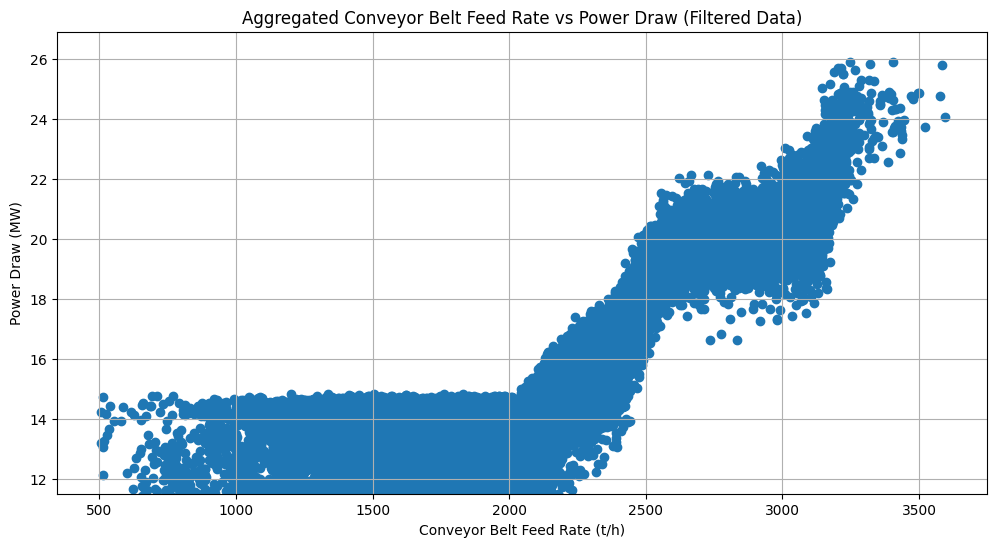

In [ ]:
filtered_df = data[data['Conveyor Belt Feed Rate (t/h)'] > 500]
bins = np.linspace(filtered_df['Conveyor Belt Feed Rate (t/h)'].min(), filtered_df['Conveyor Belt Feed Rate (t/h)'].max(), 100000)
filtered_df['binned'] = np.digitize(filtered_df['Conveyor Belt Feed Rate (t/h)'], bins)

# Aggregate the data
agg_df = filtered_df.groupby('binned').agg({'Conveyor Belt Feed Rate (t/h)': 'mean', 'Power Draw (MW)': 'mean'}).reset_index()

plt.figure(figsize=(12, 6))
plt.scatter(agg_df['Conveyor Belt Feed Rate (t/h)'], agg_df['Power Draw (MW)'])
plt.ylim(11.5, agg_df['Power Draw (MW)'].max() + 1)  # Setting y-axis limit to start from 11.5
plt.xlabel('Conveyor Belt Feed Rate (t/h)')
plt.ylabel('Power Draw (MW)')
plt.title('Aggregated Conveyor Belt Feed Rate vs Power Draw (Filtered Data)')
plt.grid(True)
plt.show()

The last graph show the 138241 datapoints grouped in 100000 to avoid outlayers when looking at the graph. With this graph we can see that depending of the conveyor feed rate the power draw varies and we can get a better optimization of the system (Conveyor Belt Feed Rate (t/h) / Power Draw (MW)) feeding the system at some Conveyor Feed Rate (t/h). To resolve with problem we can use a **optimization algorithm** like scipy optimize. But there is a problem, for the optimization algorithm we need a **objective function** for calculating **y** (Power Draw (MW)) using **x** (Conveyor Belt Feed Rate (t/h)).

How we can preict y using x?

With a **Neural Network**.

So let's do that:

In [ ]:
# Standard deviation
nbins = 200

bin_edges = np.histogram_bin_edges(data['Conveyor Belt Feed Rate (t/h)'], bins=nbins)
bin_indices = np.digitize(data['Conveyor Belt Feed Rate (t/h)'], bin_edges)

# Calculate standard deviation for each bin
std_devs = []
bin_centers = []
for i in range(1, len(bin_edges)):
    bin_data = data['Conveyor Belt Feed Rate (t/h)'][bin_indices == i]
    if len(bin_data) > 1:
        std_dev = bin_data.std()
    else:
        std_dev = 0
    std_devs.append(std_dev)
    bin_centers.append((bin_edges[i-1] + bin_edges[i]) / 2)

# Create a bar chart for standard deviation by range
fig = go.Figure()

fig.add_trace(go.Bar(
    x=bin_centers,
    y=std_devs,
    name='Standard Deviation',
    marker=dict(color='blue')
))

# Update layout
fig.update_layout(
    title='Standard Deviation by Conveyor Belt Feed Rate Range',
    xaxis_title='Conveyor Belt Feed Rate (t/h)',
    yaxis_title='Standard Deviation',
    bargap=0,
    template='plotly_white'
)

# Show the figure
fig.show()

#### We have a regular standard deviation through the different ranges, this is crucial for our problem because it means that the uncertainity on our predictions will be regular at all the ranges.

## Split data and convert it into tensors:

In [ ]:
# Assuming the features are in columns ['Bearing Pressure (kPa)', 'Speed (RPM)', 'Dilution Flow Rate (m3/h)', 'Conveyor Belt PSD Fines (%)']
# and targets are 'Conveyor Belt Feed Rate (t/h)' and 'Power Draw (MW)'
X = data[['Conveyor Belt Feed Rate (t/h)']]
y = data[[ 'Power Draw (MW)']]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


x_mean = X_train.mean()
x_std = X_train.std()
y_mean = y_train.mean()
y_std = y_train.std()

# Apply it to our data ((data - mean)/std)
X_train = (X_train - x_mean) / x_std
y_train = (y_train - y_mean) / y_std

# per entrenar el model les dates
#del test no les normalitzem
X_test = (X_test - x_mean) / x_std
y_test = (y_test - y_mean) / y_std

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)


## Building the NN

In [ ]:
class MultiOutputNN(nn.Module):
    def __init__(self):
        super(MultiOutputNN, self).__init__()
        self.fc1 = nn.Linear(1, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Create model instance
model = MultiOutputNN()

## Training the NN

In [ ]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Define tolerance for accuracy
tolerance = 0.1

# Train the model
num_epochs = 1000
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    # Calculate train accuracy
    train_accuracy = torch.mean((torch.abs(outputs - y_train_tensor) < tolerance).float()).item()
    train_accuracies.append(train_accuracy)

    # Evaluate on test data
    model.eval()
    with torch.no_grad():
        y_test_pred_tensor = model(X_test_tensor)
        test_loss = criterion(y_test_pred_tensor, y_test_tensor)
        test_losses.append(test_loss.item())

        # Calculate test accuracy
        test_accuracy = torch.mean((torch.abs(y_test_pred_tensor - y_test_tensor) < tolerance).float()).item()
        test_accuracies.append(test_accuracy)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}, Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}')

# Final evaluation on the test set
model.eval()
with torch.no_grad():
    y_test_pred_tensor = model(X_test_tensor)
    y_test_pred = y_test_pred_tensor.numpy()

mse = mean_squared_error(y_test, y_test_pred, multioutput='raw_values')
print(f'Mean Squared Error: Power Draw: {mse[0]}')

Epoch [10/1000], Train Loss: 0.8998, Test Loss: 0.8621, Train Accuracy: 0.0653, Test Accuracy: 0.0653
Epoch [20/1000], Train Loss: 0.6540, Test Loss: 0.6256, Train Accuracy: 0.0906, Test Accuracy: 0.0909
Epoch [30/1000], Train Loss: 0.4625, Test Loss: 0.4406, Train Accuracy: 0.1313, Test Accuracy: 0.1348
Epoch [40/1000], Train Loss: 0.3142, Test Loss: 0.2981, Train Accuracy: 0.1905, Test Accuracy: 0.1969
Epoch [50/1000], Train Loss: 0.2092, Test Loss: 0.1990, Train Accuracy: 0.2485, Test Accuracy: 0.2526
Epoch [60/1000], Train Loss: 0.1485, Test Loss: 0.1437, Train Accuracy: 0.2756, Test Accuracy: 0.2808
Epoch [70/1000], Train Loss: 0.1246, Test Loss: 0.1233, Train Accuracy: 0.2894, Test Accuracy: 0.2919
Epoch [80/1000], Train Loss: 0.1194, Test Loss: 0.1194, Train Accuracy: 0.2900, Test Accuracy: 0.2914
Epoch [90/1000], Train Loss: 0.1181, Test Loss: 0.1183, Train Accuracy: 0.2904, Test Accuracy: 0.2912
Epoch [100/1000], Train Loss: 0.1166, Test Loss: 0.1167, Train Accuracy: 0.2933, T

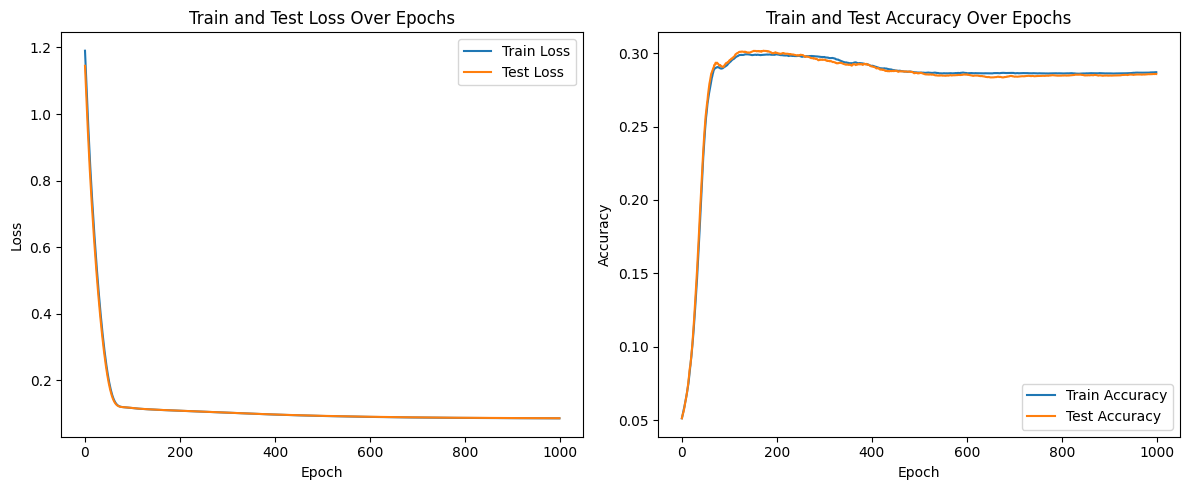

In [ ]:
# Plot train and test loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Test Loss Over Epochs')
plt.legend()

# Plot train and test accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

### Feeding the machine with a feed rate larger than 3300 can cause damage to the machinery; therefore, the limit for the feed rate is 3300.

In [ ]:
count_greater_than_3000 = data[data['Conveyor Belt Feed Rate (t/h)'] > 3000].shape[0]
count_greater_than_3300 = data[data['Conveyor Belt Feed Rate (t/h)'] > 3300].shape[0]
print('count_greater_than_3000',count_greater_than_3000)
print('count_greater_than_3300',count_greater_than_3300)

count_greater_than_3000 9857
count_greater_than_3300 58


#### Inferencing the model

In [ ]:
def inferencing(X): # (X_test_tensor, x_mean, x_std, y_std, y_mean, model)
  x_n = (X - x_mean) / x_std
  x_n_t = torch.tensor(x_n, dtype=torch.float32)

  model.eval()
  with torch.inference_mode():
    y_preds = model(x_n_t)
    y_p_original = y_preds.detach().numpy()  * y_std + y_mean
  return y_p_original

In [ ]:
# Test
X = 3350
y_p = inferencing(X)
print(y_p)
print(X/y_p)

Power Draw (MW)    24.248679
dtype: float64
Power Draw (MW)    138.151854
dtype: float64


# Optimization

## a) Objective function

In [ ]:
def objective(X): # (X_test_tensor, x_mean, x_std, y_std, y_mean, model)
  x_n = (X - x_mean) / x_std
  x_n_t = torch.tensor(x_n, dtype=torch.float32)

  model.eval()
  with torch.inference_mode():
    y_preds = model(x_n_t)
    y_p_original = y_preds.detach().numpy()  * y_std + y_mean
  return  (-X/y_p_original).iloc[0]#, y_p_original

In [ ]:
# Test
X = 3350
result = objective(X)
print(result)

-138.15185434428741


## Graph using the **NN and the objective function** to predict **y** (Power Draw (MW)) using **x** (Conveyor Belt Feed Rate (t/h)).

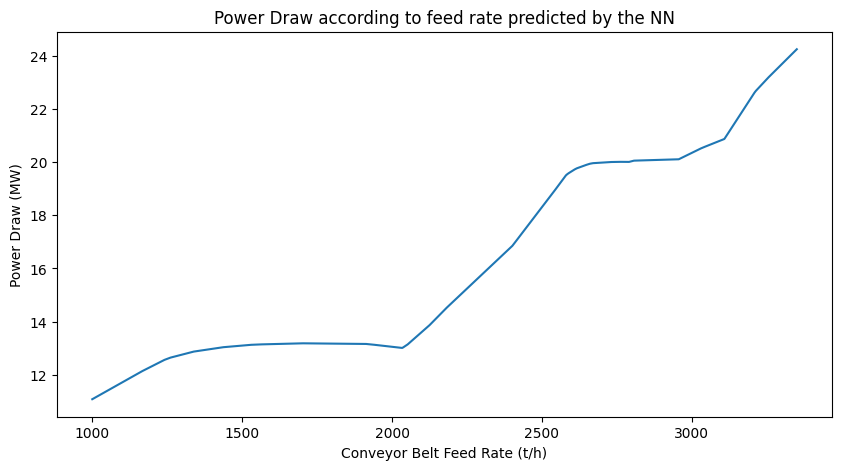

In [ ]:
range = np.linspace(1000, 3350, 2000)
y_p = []
for x in range:
  y_p.append(inferencing(x))

plt.figure(figsize=(10, 5))
plt.plot(range, y_p)
plt.xlabel('Conveyor Belt Feed Rate (t/h)')
plt.ylabel('Power Draw (MW)')
plt.title('Power Draw according to feed rate predicted by the NN')

plt.show()

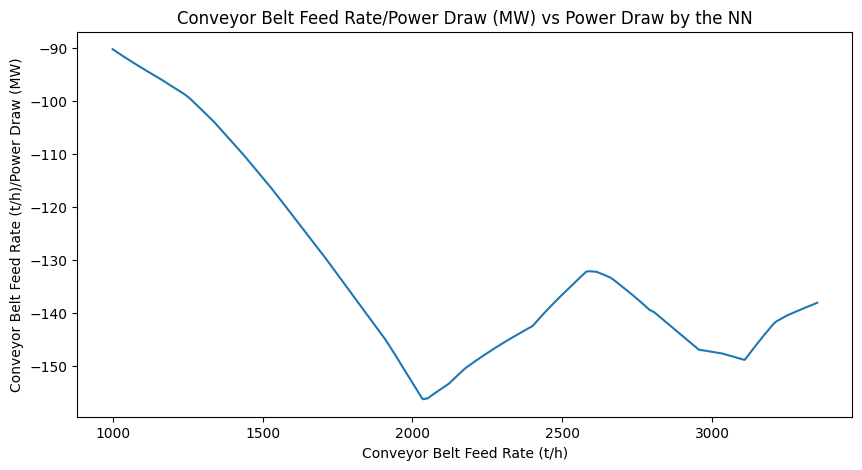

In [ ]:
range = np.linspace(1000, 3350, 1000)
y_p = []
for x in range:
  y_p.append(objective(x))

plt.figure(figsize=(10, 5))
plt.plot(range, y_p)
plt.xlabel('Conveyor Belt Feed Rate (t/h)')
plt.ylabel('Conveyor Belt Feed Rate (t/h)/Power Draw (MW)')
plt.title('Conveyor Belt Feed Rate/Power Draw (MW) vs Power Draw by the NN')
#plt.axvline(x=3102.9, color='r', linestyle='--', label='Feed Rate t/h')
#plt.axvline(x=2085.2, color='r', linestyle='--', label='Feed Rate t/h')

plt.show()

## b) Apply the optimization function



In [ ]:
bounds = [(1000, 3300)]
# Use Differential Evolution to find the global minimum
result = optimize.differential_evolution(objective, bounds)

# Extract the optimal feed rate and corresponding power draw
optimal_conveyor_feed_rate = result.x[0]
optimal_conveyor_feed_rate_divided_by_max_power_draw = -result.fun
opt_power_draw = optimal_conveyor_feed_rate / optimal_conveyor_feed_rate_divided_by_max_power_draw

print(f'Optimal feed rate: {optimal_conveyor_feed_rate:.2f} T/h')
print(f'Power Draw: {opt_power_draw:.2f} MW')
print(f'Production by unit of energy: {optimal_conveyor_feed_rate_divided_by_max_power_draw:.2f}')

Optimal feed rate: 2035.14 T/h
Power Draw: 13.02 MW
Production by unit of energy: 156.36


In [ ]:
optimal_efficiency = optimal_conveyor_feed_rate/opt_power_draw
optimal_efficiency

156.3641171776567

In [ ]:
actual_efficiency = data['Conveyor Belt Feed Rate (t/h)'].sum()/data['Power Draw (MW)'].sum()
actual_efficiency

138.53281637135376

In [ ]:
efficiency_comparison = -(actual_efficiency / optimal_efficiency) * 100 + 100
print(f"Optimal conditions compared to the actual efficiency are {efficiency_comparison:.2f}% more efficient.")

Optimal conditions compared to the actual efficiency are 11.40% more efficient.


## b) Economic Optimicization function

### If the system it's working at the optimum feed rate compared to the mean production/consumption it will be 11.4% more efficient.

### Looking at the previous optimization we can afirm that if the objective is to produce at the maximum efficency the best option is a feed rate of 2035.14 T/h but in the practical world this problem focus to get the better price of production considering price of energy and fixed costs to run the company. So we are gone a reformulate the objective function for working with energy prices and fixed costs and see if we get a different result.

#### Costs:
- MW/h: 160 Eur.
- Fixed Costs/h: 2000 Eur.

- Price mineral 1.9 EurxT

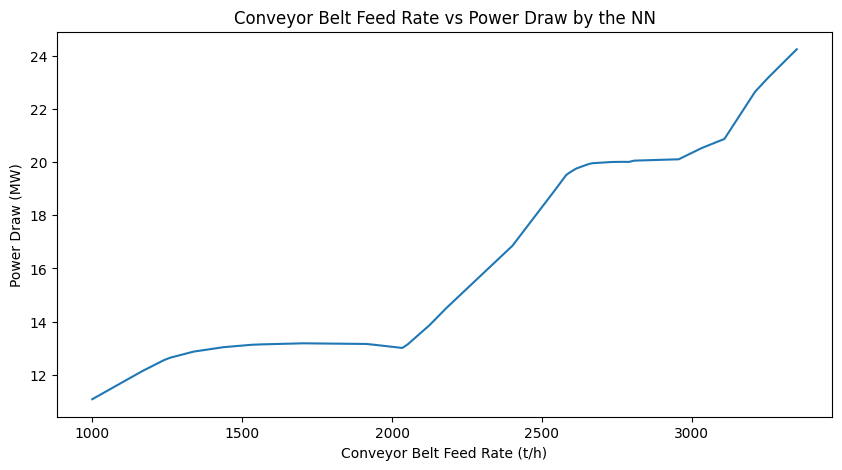

In [ ]:
range = np.linspace(1000, 3350, 2000)
y_p = []
for x in range:
  y_p.append(inferencing(x))

plt.figure(figsize=(10, 5))
plt.plot(range, y_p)
plt.xlabel('Conveyor Belt Feed Rate (t/h)')
plt.ylabel('Power Draw (MW)')
plt.title('Conveyor Belt Feed Rate vs Power Draw by the NN')

plt.show()

 ## -X*1.9+y_p_original*160 + 2000

In [ ]:
def objective_economic_graph(X): # (X_test_tensor, x_mean, x_std, y_std, y_mean, model)
  x_n = (X - x_mean) / x_std
  x_n_t = torch.tensor(x_n, dtype=torch.float32)

  model.eval()
  with torch.inference_mode():
    y_preds = model(x_n_t)
    y_p_original = y_preds.detach().numpy()  * y_std + y_mean
    return  X*1.9-y_p_original*160 - 2000, y_p_original

In [ ]:
def objective_economic(X): # (X_test_tensor, x_mean, x_std, y_std, y_mean, model)
  x_n = (X - x_mean) / x_std
  x_n_t = torch.tensor(x_n, dtype=torch.float32)

  model.eval()
  with torch.inference_mode():
    y_preds = model(x_n_t)
    y_p_original = y_preds.detach().numpy()  * y_std + y_mean
    return  (-X*1.9+y_p_original*160 + 2000)[0]

In [ ]:
bounds = [(1000, 3300)]
# Use Differential Evolution to find the global minimum
result = optimize.differential_evolution(objective_economic, bounds)

# Extract the optimal feed rate and corresponding power draw
optimal_conveyor_feed_rate = result.x[0]
optimal_conveyor_feed_rate_divided_by_max_power_draw = -result.fun
opt_power_draw = optimal_conveyor_feed_rate/optimal_conveyor_feed_rate_divided_by_max_power_draw

print(f'Optim feed rate: {optimal_conveyor_feed_rate:.2f} T/h')

benefit, power = objective_economic_graph(optimal_conveyor_feed_rate)
print(f'Power Draw: {power.iloc[0]:.2f} MW')
print(f'Maxim Benefit: {benefit.iloc[0]:.2f} Eur per hour')

Optim feed rate: 3107.70 T/h
Power Draw: 20.87 MW
Maxim Benefit: 565.76 Eur per hour


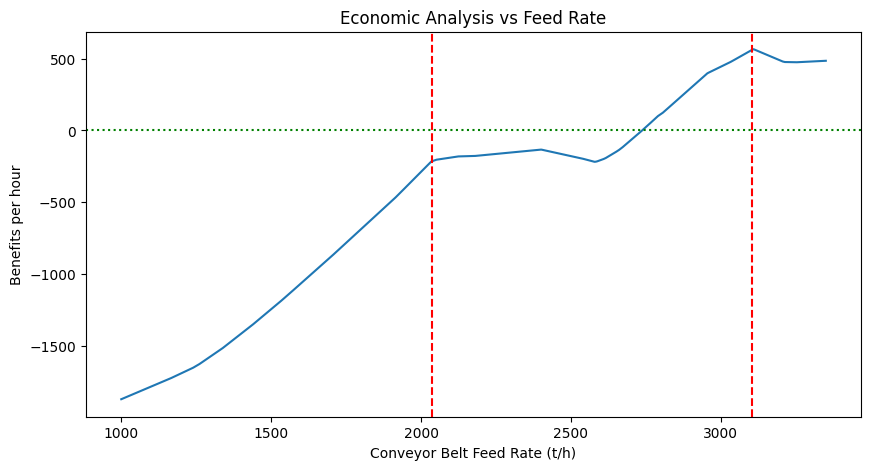

In [ ]:
range = np.linspace(1000, 3350, 1000)

benefits = []
y_p_power = []

for x in range:
  ben, power = objective_economic_graph(x) # Unpack the tuple
  benefits.append(ben)
  y_p_power.append(power)

plt.figure(figsize=(10, 5))
# Plot the cost values
plt.plot(range, benefits, label='Cost')
# Plot the power draw values
plt.xlabel('Conveyor Belt Feed Rate (t/h)')
plt.ylabel('Benefits per hour') # Adjust the y-axis label
plt.title('Economic Analysis vs Feed Rate')
#plt.axvline(x=2046, color='r', linestyle='--', label='Feed Rate t/h')
plt.axvline(x=3102.9, color='r', linestyle='--', label='Feed Rate t/h')
plt.axvline(x=2035.2, color='r', linestyle='--', label='Feed Rate t/h')
plt.axhline(y=0, color='g', linestyle=':', label='Benefit')

plt.show()